# Pick out cues from Accelerometer data

Alternative alignment extraction path for multidevice accelerometry recordings. 

Some recordings include only one tapping or clapping cue, some include multiple.

For a single accelerometry recording:

    0. Load accelerometry file, resample and collapse to 1D absolut Jerk. 
    1. Load all relevant template cues and their approximate position.
    2. Automate IDing each synchronisation cue in the  with cross correlations.
    3. Review cue timing
    4. Save the detected timing of each cue IN DEVICE TIMESTAMP VALUES
    
Output timing information is used in a difference script to shift recordings to common concert time.

## libraries and function files

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport eq
%aimport qex
%aimport al

In [3]:
%reload_ext autoreload

# Sensor Recording Metadata

In [5]:
Part_Dets = pd.read_csv('../Data/Participant_Metadata.csv', index_col = 0)
Part_Dets.columns

Index(['Section', 'Instrument', 'Con1', 'Con2', 'Con3', 'Con4', 'Con5', 'Con6',
       'P_RG', 'P_RE', 'P_RD', 'P_C1', 'P_C2', 'P_C3', 'P_C4', 'P_C5', 'M_RG',
       'M_RE', 'M_RD', 'M_C1', 'M_C2', 'M_C3', 'M_C4', 'M_C5', 'Summary',
       'Note'],
      dtype='object')

In [28]:
AX3_users = Part_Dets.loc[Part_Dets.loc[:,['M_RG','M_RE', 'M_RD', 'M_C1', 'M_C2', 'M_C3', 'M_C4', 'M_C5']].sum(axis=1)>0,['M_RG',
       'M_RE', 'M_RD', 'M_C1', 'M_C2', 'M_C3', 'M_C4', 'M_C5']]
for c in ['M_RG','M_RE', 'M_RD', 'M_C1', 'M_C2', 'M_C3', 'M_C4', 'M_C5']:
    AX3_users.loc[AX3_users.loc[:,c].isna(),c] = 0.0
    AX3_users.loc[:,c] = AX3_users.loc[:,c].astype('int32').astype('str')
AX3_users

,M_RG,M_RE,M_RD,M_C1,M_C2,M_C3,M_C4,M_C5,Note
PartID,,,,,,,,,
LS401,14564,14564,14564,14564,14564,14564,14564,14564,"Wore was on 14819 on tuesday, but didn't retur..."
LS405,17510,17510,17510,17510,17510,17510,17510,17510,NaN
LS406,14341,14341,14341,14341,14341,14341,14341,14341,NaN
LS407,14893,14893,14893,14893,14893,14893,14893,14893,NaN
LS408,14266,14266,14266,14266,14266,14266,14266,14266,No Tuesday Data
VN101,14155,14155,14155,14155,14155,14155,14155,14155,NaN
VN102,17753,17753,17753,17753,17753,17753,17753,17753,Concert Master
VN103,14452,14452,14452,14452,14452,14452,14452,14452,NaN
VN104,14083,14083,14083,14083,14083,14083,14083,14083,NaN


In [171]:
ax3_files = pd.DataFrame(index =AX3_users.index,columns = ['RG','RE','RD','C1','C2','C3','C4','C5'])

ax3_data_loc = '../Data/AX3/150223/'
concert = 'RG'
files = os.listdir(ax3_data_loc)
for f in files: 
    if f.endswith('.csv'):
        ax3_files.loc[AX3_users.loc[:,'M_'+concert].str.startswith(f[:5]),concert] = ax3_data_loc + f

ax3_data_loc = '../Data/AX3/150223/'
concert = 'RE'
files = os.listdir(ax3_data_loc)
for f in files: 
    if f.endswith('.csv'):
        ax3_files.loc[AX3_users.loc[:,'M_'+concert].str.startswith(f[:5]),concert] = ax3_data_loc + f

ax3_data_loc = '../Data/AX3/150223/'
concert = 'RD'
files = os.listdir(ax3_data_loc)
for f in files: 
    if f.endswith('.csv'):
        ax3_files.loc[AX3_users.loc[:,'M_'+concert].str.startswith(f[:5]),concert] = ax3_data_loc + f
    
ax3_data_loc = '../Data/AX3/160223/'
concert = 'C1'
files = os.listdir(ax3_data_loc)
for f in files: 
    if f.endswith('.csv'):
        ax3_files.loc[AX3_users.loc[:,'M_'+concert].str.startswith(f[:5]),concert] = ax3_data_loc + f

ax3_data_loc = '../Data/AX3/160223/'
concert = 'C2'
files = os.listdir(ax3_data_loc)
for f in files: 
    if f.endswith('.csv'):
        ax3_files.loc[AX3_users.loc[:,'M_'+concert].str.startswith(f[:5]),concert] = ax3_data_loc + f

ax3_data_loc = '../Data/AX3/170223/'
concert = 'C3'
files = os.listdir(ax3_data_loc)
for f in files: 
    if f.endswith('.csv'):
        ax3_files.loc[AX3_users.loc[:,'M_'+concert].str.startswith(f[:5]),concert] = ax3_data_loc + f

ax3_data_loc = '../Data/AX3/170223/'
concert = 'C4'
files = os.listdir(ax3_data_loc)
for f in files: 
    if f.endswith('.csv'):
        ax3_files.loc[AX3_users.loc[:,'M_'+concert].str.startswith(f[:5]),concert] = ax3_data_loc + f

ax3_data_loc = '../Data/AX3/180223/'
concert = 'C5'
files = os.listdir(ax3_data_loc)
for f in files: 
    if f.endswith('.csv'):
        ax3_files.loc[AX3_users.loc[:,'M_'+concert].str.startswith(f[:5]),concert] = ax3_data_loc + f
ax3_files

,RG,RE,RD,C1,C2,C3,C4,C5
PartID,,,,,,,,
LS401,../Data/AX3/150223/14564_0000001508.csv,../Data/AX3/150223/14564_0000001508.csv,../Data/AX3/150223/14564_0000001508.csv,../Data/AX3/160223/14564_0000001608.csv,../Data/AX3/160223/14564_0000001608.csv,../Data/AX3/170223/14564_0000001708.csv,../Data/AX3/170223/14564_0000001708.csv,../Data/AX3/180223/14564_0000001808.csv
LS405,../Data/AX3/150223/17510_0000001513.csv,../Data/AX3/150223/17510_0000001513.csv,../Data/AX3/150223/17510_0000001513.csv,../Data/AX3/160223/17510_0000001613.csv,../Data/AX3/160223/17510_0000001613.csv,../Data/AX3/170223/17510_0000001713.csv,../Data/AX3/170223/17510_0000001713.csv,../Data/AX3/180223/17510_0000001813.csv
LS406,../Data/AX3/150223/14341_0000001502.csv,../Data/AX3/150223/14341_0000001502.csv,../Data/AX3/150223/14341_0000001502.csv,../Data/AX3/160223/14341_0000001602.csv,../Data/AX3/160223/14341_0000001602.csv,../Data/AX3/170223/14341_0000001702.csv,../Data/AX3/170223/14341_0000001702.csv,../Data/AX3/180223/14341_0000001802.csv
LS407,../Data/AX3/150223/14893_0000001501.csv,../Data/AX3/150223/14893_0000001501.csv,../Data/AX3/150223/14893_0000001501.csv,../Data/AX3/160223/14893_0000001601.csv,../Data/AX3/160223/14893_0000001601.csv,../Data/AX3/170223/14893_0000001701.csv,../Data/AX3/170223/14893_0000001701.csv,../Data/AX3/180223/14893_0000001801.csv
LS408,../Data/AX3/150223/14266_0000001517.csv,../Data/AX3/150223/14266_0000001517.csv,../Data/AX3/150223/14266_0000001517.csv,../Data/AX3/160223/14266_0000001617.csv,../Data/AX3/160223/14266_0000001617.csv,../Data/AX3/170223/14266_0000001717.csv,../Data/AX3/170223/14266_0000001717.csv,../Data/AX3/180223/14266_0000001817.csv
VN101,../Data/AX3/150223/14155_0000001514.csv,../Data/AX3/150223/14155_0000001514.csv,../Data/AX3/150223/14155_0000001514.csv,../Data/AX3/160223/14155_0000001614.csv,../Data/AX3/160223/14155_0000001614.csv,../Data/AX3/170223/14155_0000001714.csv,../Data/AX3/170223/14155_0000001714.csv,../Data/AX3/180223/14155_0000001814.csv
VN102,../Data/AX3/150223/17753_0000001515.csv,../Data/AX3/150223/17753_0000001515.csv,../Data/AX3/150223/17753_0000001515.csv,../Data/AX3/160223/17753_0000001615.csv,../Data/AX3/160223/17753_0000001615.csv,../Data/AX3/170223/17753_0000001715.csv,../Data/AX3/170223/17753_0000001715.csv,../Data/AX3/180223/17753_0000001815.csv
VN103,../Data/AX3/150223/14452_0000001511.csv,../Data/AX3/150223/14452_0000001511.csv,../Data/AX3/150223/14452_0000001511.csv,../Data/AX3/160223/14452_0000001611.csv,../Data/AX3/160223/14452_0000001611.csv,../Data/AX3/170223/14452_0000001711.csv,../Data/AX3/170223/14452_0000001711.csv,../Data/AX3/180223/14452_0000001811.csv
VN104,../Data/AX3/150223/14083_0000001505.csv,../Data/AX3/150223/14083_0000001505.csv,../Data/AX3/150223/14083_0000001505.csv,../Data/AX3/160223/14083_0000001605.csv,../Data/AX3/160223/14083_0000001605.csv,../Data/AX3/170223/14083_0000001705.csv,../Data/AX3/170223/14083_0000001705.csv,../Data/AX3/180223/14083_0000001805.csv


In [712]:
ax3_files.to_csv('raw_AX3_filelocs.csv')

In [61]:
pid = 'LS408'
sigFileLoc = ax3_files.loc[pid,concert]
V = pd.read_csv(sigFileLoc,header = None)
print(V.loc[0,:])
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V[0]).dt.tz_localize('Europe/Oslo')
df = V.loc[:,[1,2,3]]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))

ACC.iloc[:5,:]

0    2023-02-18 14:10:11.479
1                  -0.078125
2                  -0.515625
3                      0.375
Name: 0, dtype: object


,dev_dTime,signal
0,2023-02-18 14:10:11.479000+01:00,0.000000
1,2023-02-18 14:10:11.489000+01:00,0.708659
2,2023-02-18 14:10:11.500000+01:00,0.046875
3,2023-02-18 14:10:11.510000+01:00,0.000000
4,2023-02-18 14:10:11.520000+01:00,0.000000


In [59]:
ACC.loc[0,'dev_dTime'].tz_convert('UTC')


Timestamp('2023-02-18 13:10:11.479000+0000', tz='UTC')

# Cue Templates
Pull in the one or many cue templates used to locate cue timing in the jerk data

This sequence constructs the cue from a sequence of peak timings (claps or taps)

In [742]:
all_cues ={'RE_Synch':pd.to_datetime('2023-02-15 10:25:26.573+0000'),
               'RD_Synch':pd.to_datetime('2023-02-15 11:05:36.897+0000'),
               'RD_Reic': pd.to_datetime('2023-02-15 11:16:50.919+0000'),
               'RD_Reic2':pd.to_datetime('2023-02-15 12:02:00.040+0000'),# -2.46
              'C1_Synch':pd.to_datetime('2023-02-16 8:33:18.324+0000'),
               'C1_Reic':pd.to_datetime('2023-02-16 08:45:22.246+0000'),#'RE':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
               'C2_Synch':pd.to_datetime('2023-02-16 10:16:22.697+0000'),
               'C2_Reic':pd.to_datetime('2023-02-16 10:27:10.927+0000'),
              'C3_Synch':pd.to_datetime('2023-02-17 08:30:51.841000+00:00'),
               'C3_Reic':pd.to_datetime('2023-02-17 08:40:31.007000+00:00'),
               'C4_Synch': pd.to_datetime('2023-02-17 10:16:26.888000+00:00'),#'C4_Synch': pd.to_datetime('2023-02-17 10:16:29.298000+00:00'),
               'C4_Reic':pd.to_datetime('2023-02-17 10:27:20.769000+00:00'),#'C4_Reic':pd.to_datetime('2023-02-17 10:27:23.179000+00:00'),
              'C5_Synch':pd.to_datetime('2023-02-18 15:10:29.583000+00:00'),
               'C5_Reic':pd.to_datetime('2023-02-18 15:22:04.555000+00:00')}

In [737]:
synch_times = {'RE_Synch':pd.to_datetime('2023-02-15 10:25:26.573+0000'),
               'RD_Synch':pd.to_datetime('2023-02-15 11:05:36.897+0000'),
               'RD_Reic': pd.to_datetime('2023-02-15 11:16:50.719+0000'),
               'RD_Reic2':pd.to_datetime('2023-02-15 12:02:02.500+0000')}
c_types = {'RE_Synch':'taps',
               'RD_Reic': 'claps',
               'RD_Synch':'taps',
               'RD_Reic2':'claps',} 
cue_files ={'RE_Synch':'./Timing/synch_cue_taps.csv',
               'RD_Reic': './Timing/RD_Reic1.csv',
               'RD_Synch':'./Timing/synch_cue_taps.csv',
               'RD_Reic2':'./Timing/RD_Reic2.csv',} 

In [344]:
synch_times = {'C1_Synch':pd.to_datetime('2023-02-16 8:33:18.324+0000'),
               'C1_Reic':pd.to_datetime('2023-02-16 08:45:22.246+0000'),#'RE':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
               'C2_Synch':pd.to_datetime('2023-02-16 10:16:22.697+0000'),
               'C2_Reic':pd.to_datetime('2023-02-16 10:27:10.927+0000')}
c_types = {'C1_Reic':'claps',#'RE':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
                 'C2_Reic':'claps', # 97.0 
                 'C1_Synch':'taps',
                 'C2_Synch':'taps'}
cue_files ={'C1_Synch':'./Timing/short_taps.csv',
               'C1_Reic': './Timing/C1_reic_claps.csv',
               'C2_Synch':'./Timing/short_taps.csv',
               'C2_Reic':'./Timing/C2_reic_claps.csv',} 

In [164]:
synch_times = {'C3_Synch':pd.to_datetime('2023-02-17 08:30:51.841000+00:00'),
               'C3_Reic':pd.to_datetime('2023-02-17 08:40:31.007000+00:00'),
               'C4_Synch': pd.to_datetime('2023-02-17 10:16:29.298000+00:00'),
               'C4_Reic':pd.to_datetime('2023-02-17 10:27:23.179000+00:00')}
c_types = {'C3_Synch':'taps',
               'C3_Reic': 'claps',
               'C4_Synch':'taps',
               'C4_Reic': 'claps',} 
cue_files ={'C3_Synch':'./Timing/short_taps.csv',
               'C3_Reic': './Timing/C3_reic_claps.csv',
               'C4_Synch':'./Timing/short_taps.csv',
               'C4_Reic':'./Timing/C4_reic_claps.csv',} 

In [84]:
synch_times = {'C5_Synch':pd.to_datetime('2023-02-18 15:10:29.583000+00:00'),
               'C5_Reic':pd.to_datetime('2023-02-18 15:22:04.555000+00:00'),}
c_types = {'C5_Synch':'taps',
               'C5_Reic': 'claps',} 
cue_files ={'C5_Synch':'./Timing/short_taps.csv',
               'C5_Reic': './Timing/C5_claps.csv',} 

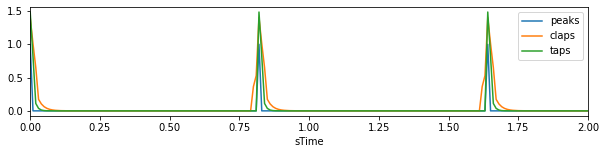

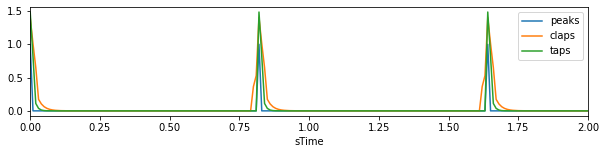

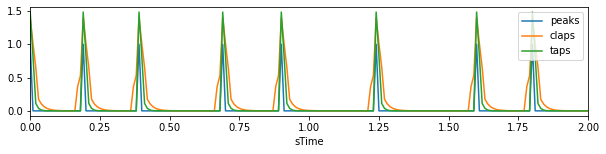

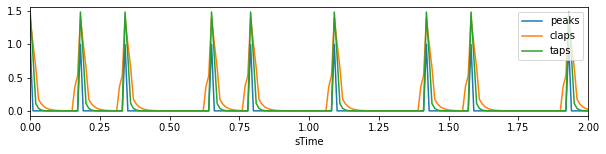

In [530]:
CueT={} # list of cues to check
# sample rate for comparison between cue template and signal
sf = 100
t_range= [-10,20]
for c in synch_times.keys():
    cue_times = pd.read_csv(cue_files[c],",",header=None)
    if len(cue_times.columns)>3:
        cue_times['S_AudioTime'] = np.round(cue_times[0],3) # reset to 50 hz
        cue_times['event'] = cue_times[1]
        cue_times['CTime'] = cue_times['S_AudioTime']-cue_times.loc[3,'S_AudioTime'] # zero on onset of first synch cue
        peak_times = cue_times.loc[cue_times['event'].str.startswith('Tap'),'CTime']
    else:
        peak_times = list(cue_times[0]-cue_times.loc[0,0])
    
    cue = al.cue_template_make(peak_times,sf,t_range)

    cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[10,2])
    plt.xlim([0,2])
    plt.show()
    CueT[c] = cue 

In [531]:
# Interval of time taken from signal to search for cue
cue

,sTime,peaks,taps,claps
0,-10.00,0,0.0,0.0
1,-9.99,0,0.0,0.0
2,-9.98,0,0.0,0.0
3,-9.97,0,0.0,0.0
4,-9.96,0,0.0,0.0
...,...,...,...,...
2995,19.95,0,0.0,0.0
2996,19.96,0,0.0,0.0
2997,19.97,0,0.0,0.0
2998,19.98,0,0.0,0.0


In [532]:
keys = list(CueT.keys())

## set up cues list

In [533]:
concert = 'RD'
cues_aligned = pd.DataFrame(columns = synch_times.keys())
player_order = list(ax3_files.index[~ax3_files.loc[:,concert].isna()])
pi = 0

cues_aligned = pd.read_csv('C3_C4_Equivitals.csv', index_col = 0)
for c in cues_aligned.columns:
    cues_aligned[c] = pd.to_datetime(cues_aligned[c])
print(len(cues_aligned))
cues_aligned

In [109]:
pid = 'VN208'
pi = 14

## Set up Cue detection through a whole set
With mechanism to correct entries

Cycle from here

In [628]:
pid= player_order[pi]
print(pid)

IndexError: list index out of range

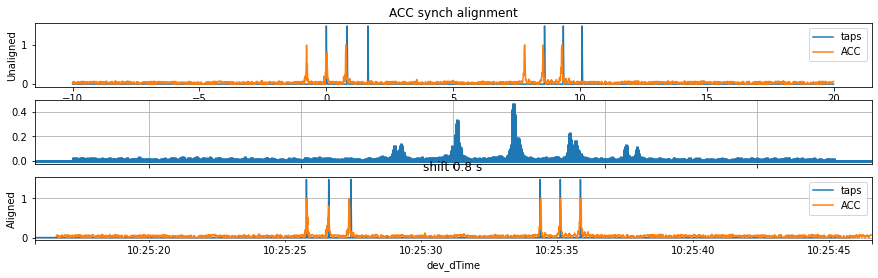

2023-02-15 10:25:25.773000+00:00


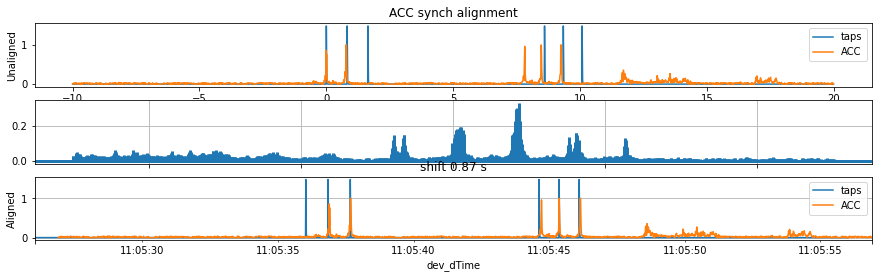

2023-02-15 11:05:36.027000+00:00


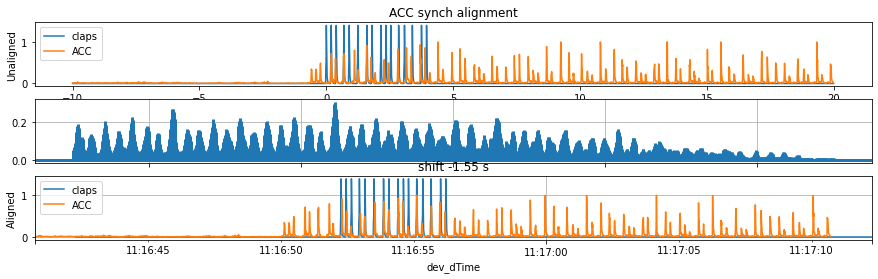

2023-02-15 11:16:52.269000+00:00


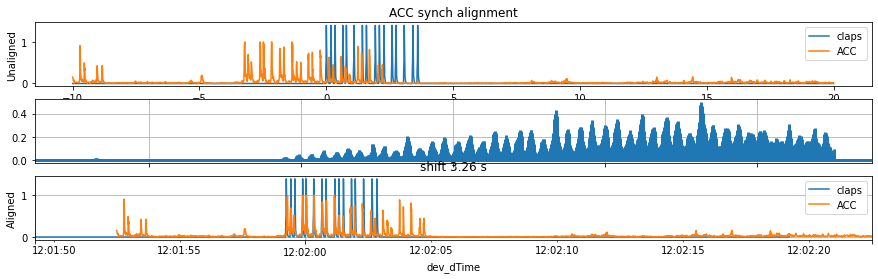

2023-02-15 12:01:59.240000+00:00


In [623]:
sigFileLoc = ax3_files.loc[pid,concert]
V = pd.read_csv(sigFileLoc,header = None)
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V[0]).dt.tz_localize('Europe/Oslo').dt.tz_convert('UTC')
df = V.loc[:,[1,2,3]]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))

Results = {}

for c in synch_times.keys():
    cue = CueT[c].copy()
    prelim_synch_time = synch_times[c]
    c_type = c_types[c] 

    Res = al.min_align(ACC,cue.loc[:,['sTime',c_type]],prelim_synch_time,5)
    Results[c] = Res
    cues_aligned.loc[pid,c] = Res['best']
    print(Res['best'])

In [627]:
cues_aligned.to_csv('RE_RD_AX3s.csv')
pi+=1
cues_aligned.iloc[-2:,:]

,RE_Synch,RD_Synch,RD_Reic,RD_Reic2
VN106,2023-02-15 10:25:25.773000+00:00,2023-02-15 11:05:36.107000+00:00,2023-02-15 11:16:50.139000+00:00,2023-02-15 12:01:59.250000+00:00
VN108,2023-02-15 10:25:25.773000+00:00,2023-02-15 11:05:36.027000+00:00,2023-02-15 11:16:50.149000+00:00,2023-02-15 12:01:59.240000+00:00


Check individual alignments

In [624]:
i = 2
c=keys[i]
print(c)

RD_Reic


In [580]:
cues_aligned.loc[pid,c] = np.datetime64('NaT')

RD_Reic


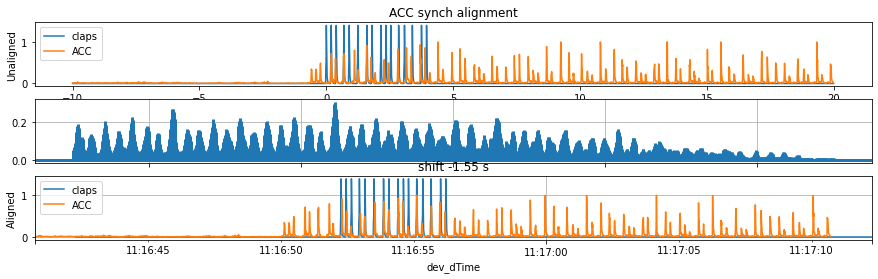

,ind,corr,shift s
0,7,0.185877,-4.93
1,43,0.201784,-4.57
2,78,0.222710,-4.22
3,98,0.179651,-4.02
4,132,0.266428,-3.68
5,185,0.213778,-3.15
6,220,0.220020,-2.80
7,255,0.205387,-2.45
8,273,0.185237,-2.27
9,291,0.224346,-2.09


In [625]:
print(c)
shift_limits = 5 # set the range of shifts (+/-) tests. It can be up to the length used to generate the results
Res = al.min_align(ACC,CueT[c].loc[:,['sTime',c_types[c]]],synch_times[c],shift_limits)

ccthresh = 0.17
peaks = al.alt_xc_peaks(Res,ccthresh)
peaks

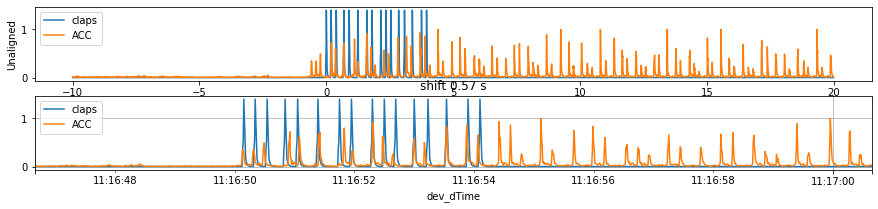

2023-02-15 11:16:50.149000+00:00


In [626]:
# specify the shift 6ou want to check by peak or enter a shift offset in seconds in test_shift
pk_int = 20
cues_aligned.loc[pid,c] = al.test_shift(Res,peaks.loc[pk_int,'shift s'])
print(cues_aligned.loc[pid,c])

In [327]:
pid

'BR602'

# device time variance

In [629]:
cols = cues_aligned.columns
cols 

Index(['RE_Synch', 'RD_Synch', 'RD_Reic', 'RD_Reic2'], dtype='object')

In [630]:
cues_aligned

,RE_Synch,RD_Synch,RD_Reic,RD_Reic2
LS401,2023-02-15 10:25:25.663000+00:00,2023-02-15 11:05:36.007000+00:00,2023-02-15 11:16:50.119000+00:00,2023-02-15 12:01:59.220000+00:00
LS405,2023-02-15 10:25:25.923000+00:00,2023-02-15 11:05:36.167000+00:00,2023-02-15 11:16:50.329000+00:00,2023-02-15 12:01:59.510000+00:00
LS406,2023-02-15 10:25:25.783000+00:00,2023-02-15 11:05:36.047000+00:00,2023-02-15 11:16:50.039000+00:00,2023-02-15 12:01:59.160000+00:00
LS407,2023-02-15 10:25:25.833000+00:00,2023-02-15 11:05:36.137000+00:00,2023-02-15 11:16:50.209000+00:00,2023-02-15 12:01:59.340000+00:00
LS408,2023-02-15 10:25:25.853000+00:00,2023-02-15 11:05:36.167000+00:00,2023-02-15 11:16:50.219000+00:00,2023-02-15 12:01:59.410000+00:00
VN101,2023-02-15 10:25:25.813000+00:00,2023-02-15 11:05:36.097000+00:00,2023-02-15 11:16:50.189000+00:00,2023-02-15 12:01:59.270000+00:00
VN102,2023-02-15 10:25:25.863000+00:00,2023-02-15 11:05:36.227000+00:00,2023-02-15 11:16:50.279000+00:00,2023-02-15 12:01:59.400000+00:00
VN103,2023-02-15 10:25:25.793000+00:00,2023-02-15 11:05:36.087000+00:00,2023-02-15 11:16:50.129000+00:00,2023-02-15 12:01:59.250000+00:00
VN104,2023-02-15 10:25:25.843000+00:00,2023-02-15 11:05:36.187000+00:00,2023-02-15 11:16:50.219000+00:00,2023-02-15 12:01:59.370000+00:00
VN105,2023-02-15 10:25:25.763000+00:00,2023-02-15 11:05:36.097000+00:00,2023-02-15 11:16:50.109000+00:00,2023-02-15 12:01:59.210000+00:00


In [631]:
sync_diffs = pd.DataFrame(index = cues_aligned.index)
for i in range(len(cols)):
    for j in range(i):
        dif_tag = cols[j] + '-' + cols[i]
        sync_diffs[dif_tag] = (cues_aligned[cols[j]] - cues_aligned[cols[i]]).dt.total_seconds()

sync_diffs =  sync_diffs-sync_diffs.median()
sync_diffs['Deviance'] = sync_diffs.abs().sum(axis = 1)
print(sync_diffs.median())
print(sync_diffs.std())

#sync_diffs

RE_Synch-RD_Synch    0.000000e+00
RE_Synch-RD_Reic     0.000000e+00
RD_Synch-RD_Reic     0.000000e+00
RE_Synch-RD_Reic2   -4.547474e-13
RD_Synch-RD_Reic2   -2.273737e-13
RD_Reic-RD_Reic2     0.000000e+00
Deviance             1.800000e-01
dtype: float64
RE_Synch-RD_Synch    0.039109
RE_Synch-RD_Reic     0.048336
RD_Synch-RD_Reic     0.049383
RE_Synch-RD_Reic2    0.059766
RD_Synch-RD_Reic2    0.062426
RD_Reic-RD_Reic2     0.033967
Deviance             0.133542
dtype: float64


In [632]:
sync_diffs.loc[:,'Deviance'].sort_values()

LS407    0.075
VN106    0.115
VN103    0.115
VN104    0.125
VN102    0.145
VN101    0.145
VN108    0.215
LS408    0.215
VN105    0.225
LS401    0.295
LS406    0.405
LS405    0.525
Name: Deviance, dtype: float64

# Correct excessive deviations

In [633]:
pid = 'LS405' # WW504    6107.171 vs 6107.9 ish
print(sync_diffs.loc[pid,:])

RE_Synch-RD_Synch    0.065
RE_Synch-RD_Reic    -0.030
RD_Synch-RD_Reic    -0.110
RE_Synch-RD_Reic2   -0.095
RD_Synch-RD_Reic2   -0.165
RD_Reic-RD_Reic2    -0.060
Deviance             0.525
Name: LS405, dtype: float64


In [512]:
sigFileLoc = ax3_files.loc[pid,concert]
V = pd.read_csv(sigFileLoc,header = None)
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V[0]).dt.tz_localize('Europe/Oslo').dt.tz_convert('UTC')
df = V.loc[:,[1,2,3]]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))

Results = {}

C1_Synch-C1_Reic     0.110
C1_Synch-C2_Synch    0.120
C1_Reic-C2_Synch     0.010
C1_Synch-C2_Reic     0.160
C1_Reic-C2_Reic      0.010
C2_Synch-C2_Reic     0.045
Deviance             0.455
Name: VN101, dtype: float64
C1_Synch


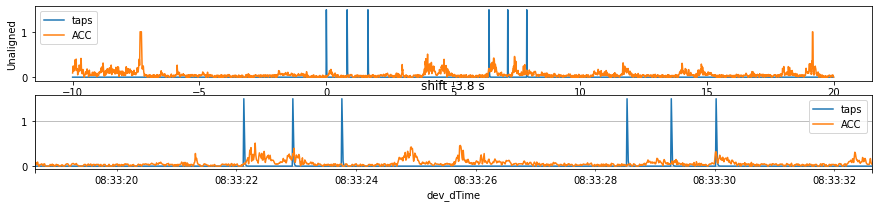

C1_Reic


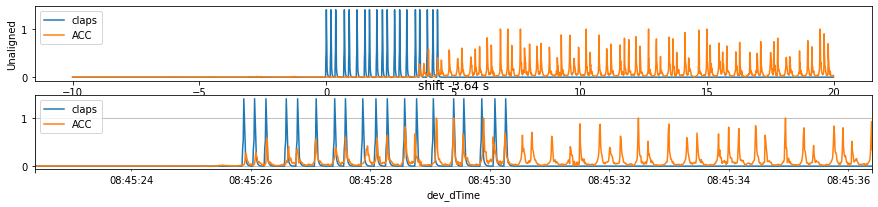

C2_Synch


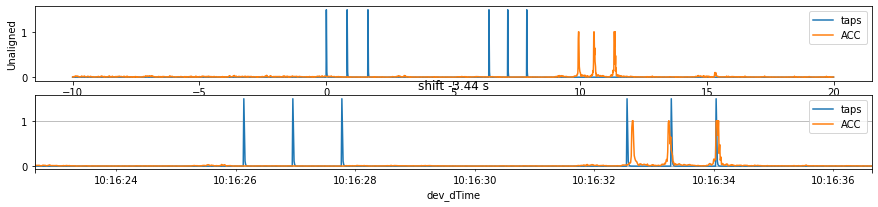

C2_Reic


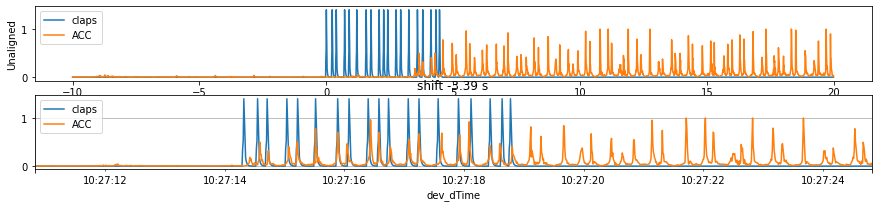

In [513]:
print(sync_diffs.loc[pid,:])
for c in synch_times.keys():
    print(c)
    cue = CueT[c].copy()
    prelim_synch_time = synch_times[c]
    c_type = c_types[c] 

    Res = al.min_align_noplot(ACC,cue.loc[:,['sTime',c_type]],prelim_synch_time,7)
    Results[c] = Res
    al.test_shift(Res,cues_aligned.loc[pid,c])

In [514]:
c = cols[0]

C1_Synch


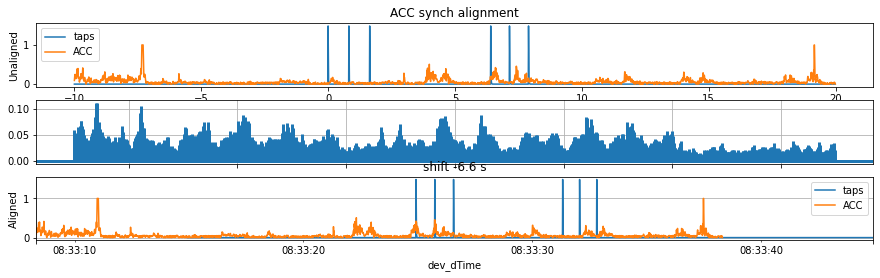

,ind,corr,shift s


In [515]:
print(c)
shift_limits = 7 # set the range of shifts (+/-) tests. It can be up to the length used to generate the results
Res = al.min_align(ACC,CueT[c].loc[:,['sTime',c_types[c]]],synch_times[c],shift_limits)

ccthresh = 0.2 # set threshold below 
peaks = al.alt_xc_peaks(Res,ccthresh)
peaks

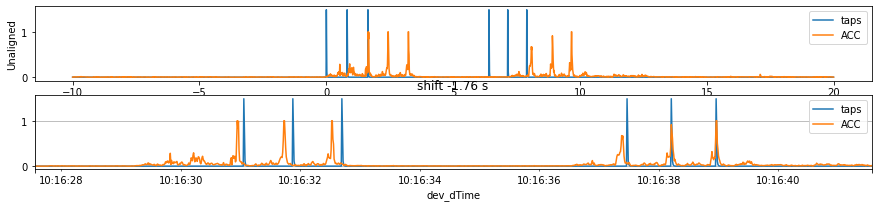

2023-02-17 10:16:31.058000+00:00


In [311]:
# specify the shift you want to check by peak or enter a shift offset in seconds in test_shift
pk_int =3
cues_aligned.loc[pid,c] = al.test_shift(Res,peaks.loc[pk_int,'shift s'])
print(cues_aligned.loc[pid,c])

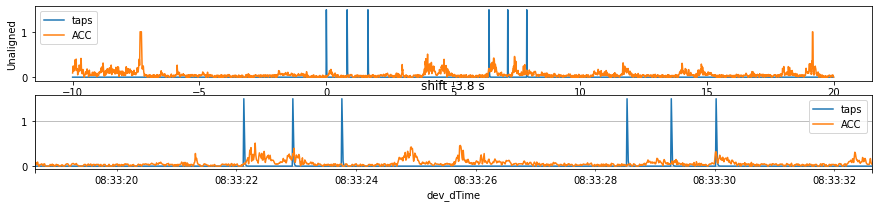

2023-02-16 08:33:22.124000+00:00


In [523]:
cues_aligned.loc[pid,c] = al.test_shift(Res,-3.8)
print(cues_aligned.loc[pid,c])

## Save after making adjustments

In [528]:
cues_aligned.to_csv('C1_C2_AX3s.csv')

# Gather and check sensor clock deviance
There is variation in alignment quality that may be due to clock drift. 

Assess whether specific sensors have a tendency to be fast or slow by comparing time between sample points on different days.


In [634]:
ax3_files

,RG,RE,RD,C1,C2,C3,C4,C5
PartID,,,,,,,,
LS401,../Data/AX3/150223/14564_0000001508.csv,../Data/AX3/150223/14564_0000001508.csv,../Data/AX3/150223/14564_0000001508.csv,../Data/AX3/160223/14564_0000001608.csv,../Data/AX3/160223/14564_0000001608.csv,../Data/AX3/170223/14564_0000001708.csv,../Data/AX3/170223/14564_0000001708.csv,../Data/AX3/180223/14564_0000001808.csv
LS405,../Data/AX3/150223/17510_0000001513.csv,../Data/AX3/150223/17510_0000001513.csv,../Data/AX3/150223/17510_0000001513.csv,../Data/AX3/160223/17510_0000001613.csv,../Data/AX3/160223/17510_0000001613.csv,../Data/AX3/170223/17510_0000001713.csv,../Data/AX3/170223/17510_0000001713.csv,../Data/AX3/180223/17510_0000001813.csv
LS406,../Data/AX3/150223/14341_0000001502.csv,../Data/AX3/150223/14341_0000001502.csv,../Data/AX3/150223/14341_0000001502.csv,../Data/AX3/160223/14341_0000001602.csv,../Data/AX3/160223/14341_0000001602.csv,../Data/AX3/170223/14341_0000001702.csv,../Data/AX3/170223/14341_0000001702.csv,../Data/AX3/180223/14341_0000001802.csv
LS407,../Data/AX3/150223/14893_0000001501.csv,../Data/AX3/150223/14893_0000001501.csv,../Data/AX3/150223/14893_0000001501.csv,../Data/AX3/160223/14893_0000001601.csv,../Data/AX3/160223/14893_0000001601.csv,../Data/AX3/170223/14893_0000001701.csv,../Data/AX3/170223/14893_0000001701.csv,../Data/AX3/180223/14893_0000001801.csv
LS408,../Data/AX3/150223/14266_0000001517.csv,../Data/AX3/150223/14266_0000001517.csv,../Data/AX3/150223/14266_0000001517.csv,../Data/AX3/160223/14266_0000001617.csv,../Data/AX3/160223/14266_0000001617.csv,../Data/AX3/170223/14266_0000001717.csv,../Data/AX3/170223/14266_0000001717.csv,../Data/AX3/180223/14266_0000001817.csv
VN101,../Data/AX3/150223/14155_0000001514.csv,../Data/AX3/150223/14155_0000001514.csv,../Data/AX3/150223/14155_0000001514.csv,../Data/AX3/160223/14155_0000001614.csv,../Data/AX3/160223/14155_0000001614.csv,../Data/AX3/170223/14155_0000001714.csv,../Data/AX3/170223/14155_0000001714.csv,../Data/AX3/180223/14155_0000001814.csv
VN102,../Data/AX3/150223/17753_0000001515.csv,../Data/AX3/150223/17753_0000001515.csv,../Data/AX3/150223/17753_0000001515.csv,../Data/AX3/160223/17753_0000001615.csv,../Data/AX3/160223/17753_0000001615.csv,../Data/AX3/170223/17753_0000001715.csv,../Data/AX3/170223/17753_0000001715.csv,../Data/AX3/180223/17753_0000001815.csv
VN103,../Data/AX3/150223/14452_0000001511.csv,../Data/AX3/150223/14452_0000001511.csv,../Data/AX3/150223/14452_0000001511.csv,../Data/AX3/160223/14452_0000001611.csv,../Data/AX3/160223/14452_0000001611.csv,../Data/AX3/170223/14452_0000001711.csv,../Data/AX3/170223/14452_0000001711.csv,../Data/AX3/180223/14452_0000001811.csv
VN104,../Data/AX3/150223/14083_0000001505.csv,../Data/AX3/150223/14083_0000001505.csv,../Data/AX3/150223/14083_0000001505.csv,../Data/AX3/160223/14083_0000001605.csv,../Data/AX3/160223/14083_0000001605.csv,../Data/AX3/170223/14083_0000001705.csv,../Data/AX3/170223/14083_0000001705.csv,../Data/AX3/180223/14083_0000001805.csv


In [665]:
AX3_users.Note

PartID
LS401    Wore was on 14819 on tuesday, but didn't retur...
LS405                                                  NaN
LS406                                                  NaN
LS407                                                  NaN
LS408                                      No Tuesday Data
VN101                                                  NaN
VN102                                       Concert Master
VN103                                                  NaN
VN104                                                  NaN
VN105                    Wednesday switched AX3 with VN106
VN106    No Tuesday Equivital data, Wednesday switched ...
VN107           No Tuesday Data, no Wednesday before lunch
VN108                                      No Tuesday data
Name: Note, dtype: object

In [743]:
cues_aligned = pd.read_csv('RE_RD_AX3s.csv', index_col = 0)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C1_C2_AX3s.csv', index_col = 0)],axis=1)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C3_C4_AX3s.csv', index_col = 0)],axis=1)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C5_AX3s.csv', index_col = 0)],axis=1)

for c in cues_aligned.columns:
    cues_aligned[c] = pd.to_datetime(cues_aligned[c])
print(len(cues_aligned))
cues_aligned

13


,RE_Synch,RD_Synch,RD_Reic,RD_Reic2,C1_Synch,C1_Reic,C2_Synch,C2_Reic,C3_Synch,C3_Reic,C4_Synch,C4_Reic,C5_Synch,C5_Reic
LS401,2023-02-15 10:25:25.663000+00:00,2023-02-15 11:05:36.007000+00:00,2023-02-15 11:16:50.119000+00:00,2023-02-15 12:01:59.220000+00:00,2023-02-16 08:33:21.924000+00:00,2023-02-16 08:45:25.856000+00:00,2023-02-16 10:16:26.057000+00:00,2023-02-16 10:27:14.287000+00:00,2023-02-17 08:30:55.911000+00:00,2023-02-17 08:40:35.047000+00:00,2023-02-17 10:16:30.948000+00:00,2023-02-17 10:27:24.759000+00:00,2023-02-18 15:10:34.463000+00:00,2023-02-18 15:22:09.485000+00:00
LS405,2023-02-15 10:25:25.923000+00:00,2023-02-15 11:05:36.167000+00:00,2023-02-15 11:16:50.329000+00:00,2023-02-15 12:01:59.510000+00:00,NaT,2023-02-16 08:45:25.956000+00:00,2023-02-16 10:16:26.227000+00:00,2023-02-16 10:27:14.497000+00:00,2023-02-17 08:30:55.941000+00:00,2023-02-17 08:40:35.137000+00:00,2023-02-17 10:16:31.058000+00:00,2023-02-17 10:27:24.979000+00:00,2023-02-18 15:10:34.833000+00:00,2023-02-18 15:22:09.935000+00:00
LS406,2023-02-15 10:25:25.783000+00:00,2023-02-15 11:05:36.047000+00:00,2023-02-15 11:16:50.039000+00:00,2023-02-15 12:01:59.160000+00:00,2023-02-16 08:33:21.944000+00:00,2023-02-16 08:45:25.806000+00:00,2023-02-16 10:16:26.087000+00:00,2023-02-16 10:27:14.217000+00:00,2023-02-17 08:30:56.011000+00:00,2023-02-17 08:40:35.127000+00:00,2023-02-17 10:16:30.988000+00:00,2023-02-17 10:27:24.849000+00:00,2023-02-18 15:10:34.733000+00:00,2023-02-18 15:22:09.695000+00:00
LS407,2023-02-15 10:25:25.833000+00:00,2023-02-15 11:05:36.137000+00:00,2023-02-15 11:16:50.209000+00:00,2023-02-15 12:01:59.340000+00:00,2023-02-16 08:33:21.964000+00:00,2023-02-16 08:45:25.896000+00:00,2023-02-16 10:16:26.187000+00:00,2023-02-16 10:27:14.367000+00:00,2023-02-17 08:30:55.931000+00:00,2023-02-17 08:40:35.127000+00:00,2023-02-17 10:16:31.018000+00:00,2023-02-17 10:27:24.909000+00:00,2023-02-18 15:10:33.773000+00:00,2023-02-18 15:22:08.825000+00:00
LS408,2023-02-15 10:25:25.853000+00:00,2023-02-15 11:05:36.167000+00:00,2023-02-15 11:16:50.219000+00:00,2023-02-15 12:01:59.410000+00:00,2023-02-16 08:33:22.044000+00:00,2023-02-16 08:45:25.916000+00:00,2023-02-16 10:16:26.227000+00:00,2023-02-16 10:27:14.457000+00:00,2023-02-17 08:30:56.021000+00:00,2023-02-17 08:40:35.147000+00:00,2023-02-17 10:16:31.108000+00:00,2023-02-17 10:27:24.989000+00:00,2023-02-18 15:10:33.543000+00:00,2023-02-18 15:22:08.585000+00:00
VN101,2023-02-15 10:25:25.813000+00:00,2023-02-15 11:05:36.097000+00:00,2023-02-15 11:16:50.189000+00:00,2023-02-15 12:01:59.270000+00:00,NaT,2023-02-16 08:45:25.886000+00:00,2023-02-16 10:16:26.137000+00:00,2023-02-16 10:27:14.317000+00:00,2023-02-17 08:30:55.861000+00:00,2023-02-17 08:40:35.077000+00:00,2023-02-17 10:16:30.958000+00:00,2023-02-17 10:27:24.789000+00:00,2023-02-18 15:10:34.733000+00:00,2023-02-18 15:22:09.765000+00:00
VN102,2023-02-15 10:25:25.863000+00:00,2023-02-15 11:05:36.227000+00:00,2023-02-15 11:16:50.279000+00:00,2023-02-15 12:01:59.400000+00:00,2023-02-16 08:33:22.044000+00:00,2023-02-16 08:45:25.916000+00:00,2023-02-16 10:16:26.237000+00:00,2023-02-16 10:27:14.457000+00:00,2023-02-17 08:30:56.021000+00:00,2023-02-17 08:40:35.217000+00:00,2023-02-17 10:16:31.148000+00:00,2023-02-17 10:27:25.019000+00:00,2023-02-18 15:10:34.843000+00:00,2023-02-18 15:22:09.845000+00:00
VN103,2023-02-15 10:25:25.793000+00:00,2023-02-15 11:05:36.087000+00:00,2023-02-15 11:16:50.129000+00:00,2023-02-15 12:01:59.250000+00:00,2023-02-16 08:33:21.944000+00:00,2023-02-16 08:45:25.896000+00:00,2023-02-16 10:16:26.047000+00:00,2023-02-16 10:27:14.317000+00:00,2023-02-17 08:30:55.891000+00:00,2023-02-17 08:40:35.087000+00:00,2023-02-17 10:16:30.978000+00:00,2023-02-17 10:27:24.809000+00:00,2023-02-18 15:10:34.703000+00:00,2023-02-18 15:22:09.745000+00:00
VN104,2023-02-15 10:25:25.843000+00:00,2023-02-15 11:05:36.187000+00:00,2023-02-15 11:16:50.219000+00:00,2023-02-15 12:01:59.370000+00:00,2023-02-16 08:33:22.084000+00:00,2023-02-16 08:45:25.94

In [749]:
all_cues = {'RE_Synch':pd.to_datetime('2023-02-15 10:25:26.573+0000'),
               'RD_Synch':pd.to_datetime('2023-02-15 11:05:36.897+0000'),
               'RD_Reic': pd.to_datetime('2023-02-15 11:16:50.919+0000'),
               'RD_Reic2':pd.to_datetime('2023-02-15 12:02:00.040+0000'),# -2.46
              'C1_Synch':pd.to_datetime('2023-02-16 8:33:18.524+0000'), # +0.2
               'C1_Reic':pd.to_datetime('2023-02-16 08:45:22.446+0000'),# +0.2
               'C2_Synch':pd.to_datetime('2023-02-16 10:16:22.697+0000'),
               'C2_Reic':pd.to_datetime('2023-02-16 10:27:10.927+0000'),
              'C3_Synch':pd.to_datetime('2023-02-17 08:30:51.841000+00:00'),
               'C3_Reic':pd.to_datetime('2023-02-17 08:40:31.007000+00:00'),
               'C4_Synch': pd.to_datetime('2023-02-17 10:16:26.888000+00:00'),#'C4_Synch': pd.to_datetime('2023-02-17 10:16:29.298000+00:00'),
               'C4_Reic':pd.to_datetime('2023-02-17 10:27:20.769000+00:00'),#'C4_Reic':pd.to_datetime('2023-02-17 10:27:23.179000+00:00'),
              'C5_Synch':pd.to_datetime('2023-02-18 15:10:29.583000+00:00'),
               'C5_Reic':pd.to_datetime('2023-02-18 15:22:04.555000+00:00')}

In [750]:
df = (cues_aligned - all_cues)#.dt.total_seconds() # (cues_aligned[cols[j]] - cues_aligned[cols[i]]).dt.total_seconds()
for c in df.columns:
    df[c] = df[c].dt.total_seconds()
df

,RE_Synch,RD_Synch,RD_Reic,RD_Reic2,C1_Synch,C1_Reic,C2_Synch,C2_Reic,C3_Synch,C3_Reic,C4_Synch,C4_Reic,C5_Synch,C5_Reic
LS401,-0.91,-0.89,-0.80,-0.82,3.40,3.41,3.36,3.36,4.07,4.04,4.06,3.99,4.88,4.93
LS405,-0.65,-0.73,-0.59,-0.53,NaN,3.51,3.53,3.57,4.10,4.13,4.17,4.21,5.25,5.38
LS406,-0.79,-0.85,-0.88,-0.88,3.42,3.36,3.39,3.29,4.17,4.12,4.10,4.08,5.15,5.14
LS407,-0.74,-0.76,-0.71,-0.70,3.44,3.45,3.49,3.44,4.09,4.12,4.13,4.14,4.19,4.27
LS408,-0.72,-0.73,-0.70,-0.63,3.52,3.47,3.53,3.53,4.18,4.14,4.22,4.22,3.96,4.03
VN101,-0.76,-0.80,-0.73,-0.77,NaN,3.44,3.44,3.39,4.02,4.07,4.07,4.02,5.15,5.21
VN102,-0.71,-0.67,-0.64,-0.64,3.52,3.47,3.54,3.53,4.18,4.21,4.26,4.25,5.26,5.29
VN103,-0.78,-0.81,-0.79,-0.79,3.42,3.45,3.35,3.39,4.05,4.08,4.09,4.04,5.12,5.19
VN104,-0.73,-0.71,-0.70,-0.67,3.56,3.50,3.49,3.50,4.09,4.11,4.17,4.13,5.19,5.28
VN105,-0.81,-0.80,-0.81,-0.83,3.48,3.46,3.44,3.45,4.08,4.11,4.07,4.11,5.21,5.27


In [751]:
df.median()

RE_Synch   -0.770
RD_Synch   -0.795
RD_Reic    -0.750
RD_Reic2   -0.780
C1_Synch    3.480
C1_Reic     3.450
C2_Synch    3.440
C2_Reic     3.400
C3_Synch    4.080
C3_Reic     4.110
C4_Synch    4.100
C4_Reic     4.080
C5_Synch    5.140
C5_Reic     5.190
dtype: float64

In [735]:
(-3.240-0.770)

-4.01

In [734]:
(3.400-3.690)

-0.29000000000000004

In [733]:
(4.080-1.670)

2.41

In [639]:
sync_diffs = pd.DataFrame(index = cues_aligned.index)
cols = cues_aligned.columns
for i in range(len(cols)):
    for j in range(i):
        dif_tag = cols[j] + '-' + cols[i]
        sync_diffs[dif_tag] = (cues_aligned[cols[j]] - cues_aligned[cols[i]]).dt.total_seconds()

sync_diffs =  sync_diffs-sync_diffs.median()
sync_diffs['Deviance'] = sync_diffs.abs().sum(axis = 1)
print(sync_diffs.median())
print(sync_diffs.std())

RE_Synch-RD_Synch    0.000000e+00
RE_Synch-RD_Reic     0.000000e+00
RD_Synch-RD_Reic     0.000000e+00
RE_Synch-RD_Reic2   -4.547474e-13
RD_Synch-RD_Reic2   -2.273737e-13
                         ...     
C3_Reic-C5_Reic      0.000000e+00
C4_Synch-C5_Reic     0.000000e+00
C4_Reic-C5_Reic      0.000000e+00
C5_Synch-C5_Reic     0.000000e+00
Deviance             4.020000e+00
Length: 92, dtype: float64
RE_Synch-RD_Synch    0.039109
RE_Synch-RD_Reic     0.048336
RD_Synch-RD_Reic     0.049383
RE_Synch-RD_Reic2    0.059766
RD_Synch-RD_Reic2    0.062426
                       ...   
C3_Reic-C5_Reic      0.421291
C4_Synch-C5_Reic     0.435556
C4_Reic-C5_Reic      0.443426
C5_Synch-C5_Reic     0.033282
Deviance             9.646408
Length: 92, dtype: float64


In [639]:
sync_diffs = pd.DataFrame(index = cues_aligned.index)
cols = cues_aligned.columns
for i in range(len(cols)):
    for j in range(i):
        dif_tag = cols[j] + '-' + cols[i]
        sync_diffs[dif_tag] = (cues_aligned[cols[j]] - cues_aligned[cols[i]]).dt.total_seconds()

sync_diffs =  sync_diffs-sync_diffs.median()
sync_diffs['Deviance'] = sync_diffs.abs().sum(axis = 1)
print(sync_diffs.median())
print(sync_diffs.std())

RE_Synch-RD_Synch    0.000000e+00
RE_Synch-RD_Reic     0.000000e+00
RD_Synch-RD_Reic     0.000000e+00
RE_Synch-RD_Reic2   -4.547474e-13
RD_Synch-RD_Reic2   -2.273737e-13
                         ...     
C3_Reic-C5_Reic      0.000000e+00
C4_Synch-C5_Reic     0.000000e+00
C4_Reic-C5_Reic      0.000000e+00
C5_Synch-C5_Reic     0.000000e+00
Deviance             4.020000e+00
Length: 92, dtype: float64
RE_Synch-RD_Synch    0.039109
RE_Synch-RD_Reic     0.048336
RD_Synch-RD_Reic     0.049383
RE_Synch-RD_Reic2    0.059766
RD_Synch-RD_Reic2    0.062426
                       ...   
C3_Reic-C5_Reic      0.421291
C4_Synch-C5_Reic     0.435556
C4_Reic-C5_Reic      0.443426
C5_Synch-C5_Reic     0.033282
Deviance             9.646408
Length: 92, dtype: float64


In [642]:
sync_d = pd.DataFrame(index = cues_aligned.index)
cols = cues_aligned.columns
for i in range(len(cols)):
    for j in range(i):
        dif_tag = cols[j] + '-' + cols[i]
        sync_d[dif_tag] = (cues_aligned[cols[j]] - cues_aligned[cols[i]]).dt.total_seconds()

print(sync_d.median())
print(sync_d.std())

RE_Synch-RD_Synch     -2410.309
RE_Synch-RD_Reic      -3084.376
RD_Synch-RD_Reic       -674.052
RE_Synch-RD_Reic2     -5793.492
RD_Synch-RD_Reic2     -3383.178
                        ...    
C3_Synch-C5_Reic    -111073.834
C3_Reic-C5_Reic     -110494.668
C4_Synch-C5_Reic    -104738.767
C4_Reic-C5_Reic     -104084.936
C5_Synch-C5_Reic       -695.032
Length: 91, dtype: float64
RE_Synch-RD_Synch    0.039109
RE_Synch-RD_Reic     0.048336
RD_Synch-RD_Reic     0.049383
RE_Synch-RD_Reic2    0.059766
RD_Synch-RD_Reic2    0.062426
                       ...   
C3_Synch-C5_Reic     0.431980
C3_Reic-C5_Reic      0.421291
C4_Synch-C5_Reic     0.435556
C4_Reic-C5_Reic      0.443426
C5_Synch-C5_Reic     0.033282
Length: 91, dtype: float64


In [646]:
sync_d[wc].median()

RE_Synch-RD_Synch   -2410.309
RE_Synch-RD_Reic    -3084.376
RD_Synch-RD_Reic     -674.052
RE_Synch-RD_Reic2   -5793.492
RD_Synch-RD_Reic2   -3383.178
RD_Reic-RD_Reic2    -2709.121
C1_Synch-C2_Reic    -6832.353
C1_Reic-C2_Reic     -6108.441
C2_Synch-C2_Reic     -648.225
C3_Synch-C3_Reic     -579.186
C3_Synch-C4_Synch   -6335.087
C3_Reic-C4_Synch    -5755.891
C3_Synch-C4_Reic    -6988.928
C3_Reic-C4_Reic     -6409.752
C4_Synch-C4_Reic     -653.861
C5_Synch-C5_Reic     -695.032
dtype: float64

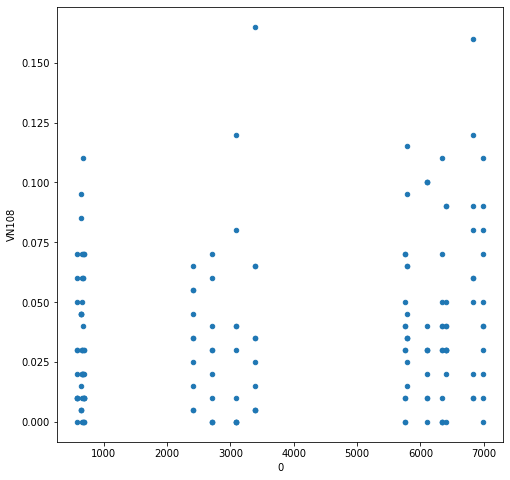

In [692]:
# ['LS401', 'LS405', 'LS406', 'LS407', 'LS408', 'VN101', 'VN102', 'VN103','VN104', 'VN105', 'VN106', 'VN107', 'VN108']
same_sensors = ['LS401', 'LS405', 'LS406', 'LS407', 'LS408', 'VN101', 'VN102', 'VN103','VN104', 'VN107', 'VN108']
A = pd.concat([-sync_d[wc].median(),sync_diffs.loc[:,wc].transpose().abs()],axis=1)
fig,ax = plt.subplots(1,1,figsize=[8,8])
for s in same_sensors:
    A.plot(x = 0,y = s,kind='scatter',ax=ax)
plt.show()

In [708]:
sync_diffs.loc[:,wc].abs().sum(axis=1)

LS401    0.61
LS405    1.07
LS406    1.01
LS407    0.34
LS408    0.67
VN101    0.48
VN102    0.56
VN103    0.29
VN104    0.40
VN105    0.50
VN106    0.58
VN108    0.65
VN107    0.32
dtype: float64

,0,1
0,1.000000,0.651666
1,0.651666,1.000000


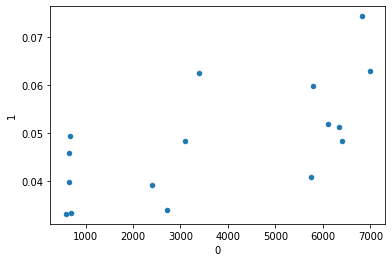

In [702]:
A = pd.concat([-sync_d[wc].median(),sync_diffs.loc[:,wc].transpose().std(axis=1)],axis=1)
A.plot(x=0,y=1,kind='scatter')
A.corr()

In [704]:
A = pd.concat([-sync_d[wc].median(),sync_diffs.loc[:,wc].transpose()],axis=1)
A.corr()

,0,LS401,LS405,LS406,LS407,LS408,VN101,VN102,VN103,VN104,VN105,VN106,VN108,VN107
0,1.000000,0.156916,-0.237031,0.168943,-0.439239,-0.645725,0.357728,-0.780640,0.236321,-0.530167,0.127488,0.541904,0.442413,-0.273447
LS401,0.156916,1.000000,0.004187,-0.310335,-0.283137,0.007575,-0.033374,-0.089221,-0.235194,-0.219621,-0.505732,0.659141,0.222281,0.116232
LS405,-0.237031,0.004187,1.000000,-0.010795,0.559388,0.512188,0.071478,-0.087127,-0.190649,-0.151474,-0.248365,-0.367858,0.538537,-0.238502
LS406,0.168943,-0.310335,-0.010795,1.000000,0.204247,0.384736,-0.056643,-0.058651,-0.108149,-0.008524,0.347805,0.265302,0.220065,-0.029040
LS407,-0.439239,-0.283137,0.559388,0.204247,1.000000,0.399158,-0.219469,0.345527,-0.370411,-0.150235,0.234978,-0.443937,0.194358,-0.713113
LS408,-0.645725,0.007575,0.512188,0.384736,0.399158,1.000000,-0.427708,0.428337,-0.257661,0.407279,-0.055755,-0.060052,-0.110113,0.175407
VN101,0.357728,-0.033374,0.071478,-0.056643,-0.219469,-0.427708,1.000000,-0.248061,-0.251684,0.109906,-0.307400,-0.068774,0.670187,0.582063
VN102,-0.780640,-0.089221,-0.087127,-0.058651,0.345527,0.428337,-0.248061,1.000000,-0.354881,0.388272,0.258756,-0.262721,-0.405790,0.079123
VN103,0.236321,-0.235194,-0.190649,-0.108149,-0.370411,-0.257661,-0.251684,-0.354881,1.000000,-0.013017,0.097727,-0.141040,-0.524767,-0.081140
VN104,-0.530167,-0.219621,-0.151474,-0.008524,-0.150235,0.407279,0.109906,0.388272,-0.013017,1.000000,-0.151014,-0.179088,-0.357928,0.874818


These results suggest that the difference in time between points PER DEVICE is contingent on the duration of that interval, and that some run fast and some run slow relative to median in ways that fit with linear clock differences. 

# translate device recording times to concert times
with just offset (sync or Reic if sync is missing)

In [711]:
pid = 'LS401'

In [645]:
sync_diffs.loc[:,wc]

,RE_Synch-RD_Synch,RE_Synch-RD_Reic,RD_Synch-RD_Reic,RE_Synch-RD_Reic2,RD_Synch-RD_Reic2,RD_Reic-RD_Reic2,C1_Synch-C2_Reic,C1_Reic-C2_Reic,C2_Synch-C2_Reic,C3_Synch-C3_Reic,C3_Synch-C4_Synch,C3_Reic-C4_Synch,C3_Synch-C4_Reic,C3_Reic-C4_Reic,C4_Synch-C4_Reic,C5_Synch-C5_Reic
LS401,-0.035,-0.08,-0.06,-0.065,-0.035,0.02,-0.01,0.01,-0.005,0.05,0.05,-0.01,0.08,0.04,0.05,0.01
LS405,0.065,-0.03,-0.11,-0.095,-0.165,-0.06,NaN,-0.10,-0.045,-0.01,-0.03,-0.03,-0.11,-0.09,-0.06,-0.07
LS406,0.045,0.12,0.06,0.115,0.065,0.00,0.08,0.03,0.095,0.07,0.11,0.03,0.09,0.03,0.00,0.07
LS407,0.005,0.00,-0.02,-0.015,-0.025,-0.01,-0.05,-0.03,0.045,-0.01,0.00,0.00,-0.05,-0.03,-0.03,-0.02
LS408,-0.005,0.01,0.00,-0.065,-0.065,-0.07,-0.06,-0.10,-0.005,0.06,0.00,-0.07,-0.04,-0.09,-0.02,-0.01
VN101,0.025,0.00,-0.04,0.035,0.005,0.04,0.16,0.01,0.045,-0.03,-0.01,0.01,0.00,0.04,0.03,0.00
VN102,-0.055,-0.04,0.00,-0.045,0.005,0.00,-0.06,-0.10,0.005,-0.01,-0.04,-0.04,-0.07,-0.05,-0.01,0.03
VN103,0.015,0.04,0.01,0.035,0.015,0.00,-0.02,0.02,-0.045,-0.01,0.00,0.00,0.01,0.03,0.03,-0.01
VN104,-0.035,0.00,0.02,-0.035,-0.005,-0.03,0.01,-0.04,-0.015,0.00,-0.04,-0.05,-0.04,-0.03,0.02,-0.03
VN105,-0.025,0.03,0.04,0.045,0.065,0.02,-0.02,-0.03,-0.015,-0.01,0.05,0.05,-0.03,-0.01,-0.06,0.00


ValueError: x and y must have same first dimension, but have shapes (16,) and (13, 16)

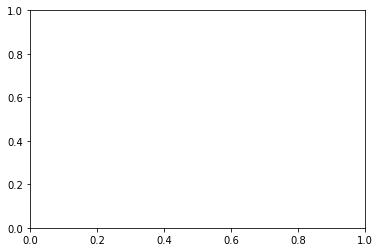

In [653]:
plt.plot(-sync_d[wc].median().values,sync_diffs.loc[:,wc])

In [644]:
wc = ['RE_Synch-RD_Synch', 'RE_Synch-RD_Reic', 'RD_Synch-RD_Reic',
       'RE_Synch-RD_Reic2', 'RD_Synch-RD_Reic2', 'RD_Reic-RD_Reic2',
 'C1_Synch-C2_Reic', 'C1_Reic-C2_Reic',  'C2_Synch-C2_Reic', 'C3_Synch-C3_Reic', 'C3_Synch-C4_Synch',
       'C3_Reic-C4_Synch', 
       'C3_Synch-C4_Reic', 'C3_Reic-C4_Reic', 'C4_Synch-C4_Reic',
       'C5_Synch-C5_Reic']

In [641]:
sync_diffs.columns

Index(['RE_Synch-RD_Synch', 'RE_Synch-RD_Reic', 'RD_Synch-RD_Reic',
       'RE_Synch-RD_Reic2', 'RD_Synch-RD_Reic2', 'RD_Reic-RD_Reic2',
       'RE_Synch-C1_Synch', 'RD_Synch-C1_Synch', 'RD_Reic-C1_Synch',
       'RD_Reic2-C1_Synch', 'RE_Synch-C1_Reic', 'RD_Synch-C1_Reic',
       'RD_Reic-C1_Reic', 'RD_Reic2-C1_Reic', 'C1_Synch-C1_Reic',
       'RE_Synch-C2_Synch', 'RD_Synch-C2_Synch', 'RD_Reic-C2_Synch',
       'RD_Reic2-C2_Synch', 'C1_Synch-C2_Synch', 'C1_Reic-C2_Synch',
       'RE_Synch-C2_Reic', 'RD_Synch-C2_Reic', 'RD_Reic-C2_Reic',
       'RD_Reic2-C2_Reic', 'C1_Synch-C2_Reic', 'C1_Reic-C2_Reic',
       'C2_Synch-C2_Reic', 'RE_Synch-C3_Synch', 'RD_Synch-C3_Synch',
       'RD_Reic-C3_Synch', 'RD_Reic2-C3_Synch', 'C1_Synch-C3_Synch',
       'C1_Reic-C3_Synch', 'C2_Synch-C3_Synch', 'C2_Reic-C3_Synch',
       'RE_Synch-C3_Reic', 'RD_Synch-C3_Reic', 'RD_Reic-C3_Reic',
       'RD_Reic2-C3_Reic', 'C1_Synch-C3_Reic', 'C1_Reic-C3_Reic',
       'C2_Synch-C3_Reic', 'C2_Reic-C3_Reic', 'C3_Sy